# Stage 2

In this section, we want to be able to come up with a predictive model to be able to soundly predict the price of AirBnB listings based on features we deem are important.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import folium

import warnings
warnings.filterwarnings("ignore")

In [3]:
df_initial = pd.read_csv('../data/listings.csv')

In [4]:
# checking shape
print("The dataset has {} rows and {} columns.".format(*df_initial.shape))

# ... and duplicates
print("It contains {} duplicates.".format(df_initial.duplicated().sum()))

The dataset has 39670 rows and 106 columns.
It contains 0 duplicates.


In [5]:
df_initial.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11156,https://www.airbnb.com/rooms/11156,20200316134854,2020-03-16,An Oasis in the City,Very central to the city which can be reached ...,Potts Pt. is a vibrant and popular inner-city...,Very central to the city which can be reached ...,none,"It is very close to everything and everywhere,...",...,f,f,moderate,f,f,1,0,1,0,1.55


In [6]:
# check the columns we currently have
df_initial.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)

## Preprocessing Data

### Deciding which columns to work with

Let's imagine we are in the shoes of someone who'd like to offer their home. Fixed features of our property include its rooms, size, and location. We also can decide on how we want to be listed: with a picture or not, how many minimum nights we want a guest to stay, whether we are instantly bookable, how we handle cancellations, etc. But we can neither be a "super host", nor do we have any reviews yet to show - although they can be very important for setting a price. So, let's focus only on features we can influence:

In [7]:
# define the columns we want to keep
columns_to_keep = ['id', 'space', 'description', 'host_has_profile_pic', 'neighbourhood_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'square_feet', 'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

df_raw = df_initial[columns_to_keep].set_index('id')
print("The dataset has {} rows and {} columns - after dropping irrelevant columns.".format(*df_raw.shape))

The dataset has 39670 rows and 23 columns - after dropping irrelevant columns.


In [8]:
# Different room types
df_raw.room_type.value_counts(normalize=True)

Entire home/apt    0.627199
Private room       0.347013
Shared room        0.019082
Hotel room         0.006705
Name: room_type, dtype: float64

In [9]:
# Different property types
df_raw.property_type.value_counts(normalize=True)

Apartment                 0.596496
House                     0.256945
Townhouse                 0.042627
Condominium               0.019813
Guest suite               0.017998
Guesthouse                0.014520
Villa                     0.009024
Loft                      0.006226
Boutique hotel            0.005798
Serviced apartment        0.005420
Bungalow                  0.004865
Cottage                   0.004285
Bed and breakfast         0.003277
Hotel                     0.002521
Hostel                    0.002395
Other                     0.001613
Cabin                     0.001588
Tiny house                0.001311
Boat                      0.000731
Camper/RV                 0.000454
Aparthotel                0.000429
Tent                      0.000277
Farm stay                 0.000252
Earth house               0.000227
Barn                      0.000151
Island                    0.000101
Chalet                    0.000101
Yurt                      0.000050
Campsite            

In [10]:
# Cleaning Price columns
df_raw[['price', 'cleaning_fee', 'extra_people', 'security_deposit']].head(3)

,price,cleaning_fee,extra_people,security_deposit
id,,,,
11156,$65.00,NaN,$0.00,NaN
12351,"$14,316.00",$55.00,$395.00,$0.00
14250,$471.00,$100.00,$40.00,$900.00


In [11]:
# Check for null values in price column
# checking Nan's in "price" column
df_raw.price.isna().sum()

0

In [12]:
# Check for nulls in cleaning_fee
df_raw.cleaning_fee.isna().sum()

10453

Plenty of null cleaning fees, so that might mean that the hosts do not charge extra for cleaning fees. So let's replace those with \$0.0 dollars.

In [13]:
df_raw.cleaning_fee.fillna('$0.00', inplace=True)
df_raw.cleaning_fee.isna().sum()

0

In [14]:
# Same for security deposit
df_raw.security_deposit.isna().sum()

13866

In [15]:
df_raw.security_deposit.fillna('$0.00', inplace=True)
df_raw.security_deposit.isna().sum()

0

In [16]:
# Let's remove the dollar signs in all four columns and convert the string values into numerical ones:

# clean up the columns (by method chaining)
df_raw.price = df_raw.price.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.cleaning_fee = df_raw.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.security_deposit = df_raw.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.extra_people = df_raw.extra_people.str.replace('$', '').str.replace(',', '').astype(float)

Investigate the `price` column. There might be cleaning need to be done here.

In [17]:
df_raw['price'].describe()

count    39670.000000
mean       218.327275
std        426.087963
min          0.000000
25%         80.000000
50%        130.000000
75%        218.000000
max      16156.000000
Name: price, dtype: float64

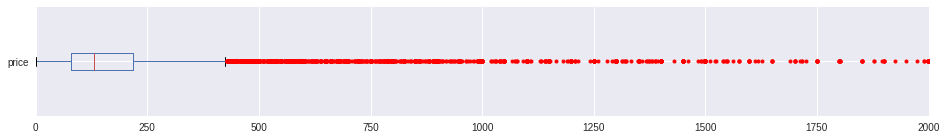

In [18]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_raw['price'].plot(kind='box', xlim=(0, 2000), vert=False, flierprops=red_square, figsize=(16,2));

The pricing data is a bit messy as expected. 75% of the apartments charge close to 200 - but the maximum value is 16000. Let's decide on a limit of \$ 1000, after which the outliers seem to 'fringe', and drop all records that charge more than that. Oddly enough, we have prices set to 0, so let's drop those too.

In [19]:
df_raw.drop(df_raw[ (df_raw.price > 500) | (df_raw.price == 0) ].index, axis=0, inplace=True)

In [20]:
print("The dataset has {} rows and {} columns - after being price-wise preprocessed.".format(*df_raw.shape))

The dataset has 37111 rows and 23 columns - after being price-wise preprocessed.


### Dealing with missing values

In [21]:
df_raw.isna().sum()

space                       11373
description                  1256
host_has_profile_pic            3
neighbourhood_cleansed          0
latitude                        0
longitude                       0
property_type                   0
room_type                       0
accommodates                    0
bathrooms                      15
bedrooms                       57
bed_type                        0
amenities                       0
square_feet                 36920
price                           0
cleaning_fee                    0
security_deposit                0
extra_people                    0
guests_included                 0
minimum_nights                  0
instant_bookable                0
is_business_travel_ready        0
cancellation_policy             0
dtype: int64

In [22]:
# drop columns with too many Nan's
df_raw.drop(columns=['square_feet', 'space'], inplace=True)

In [23]:
# drop rows with NaN's in bathrooms and bedrooms
df_raw.dropna(subset=['bathrooms', 'bedrooms', ], inplace=True)

In [24]:
df_raw.host_has_profile_pic.unique()


array(['t', 'f', nan], dtype=object)

In [25]:
# replace host_has_profile_pic Nan's with no
df_raw.host_has_profile_pic.fillna(value='f', inplace=True)
df_raw.host_has_profile_pic.unique()

array(['t', 'f'], dtype=object)

In [26]:
df_raw.isna().sum()


description                 1224
host_has_profile_pic           0
neighbourhood_cleansed         0
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                      0
bedrooms                       0
bed_type                       0
amenities                      0
price                          0
cleaning_fee                   0
security_deposit               0
extra_people                   0
guests_included                0
minimum_nights                 0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
dtype: int64

In [27]:
print("The dataset has {} rows and {} columns - after having dealt with missing values.".format(*df_raw.shape))

The dataset has 37042 rows and 21 columns - after having dealt with missing values.


## Feature Engineering

### Proximity to transport services

In [28]:
df_prox = pd.read_csv('../data/listings-proximity.csv')

df_prox.head(10)

,id,latitude,longitude,proximity
0,11156,-33.86917,151.22656,714.152785
1,12351,-33.86515,151.19190,99.764789
2,14250,-33.80093,151.26172,1614.550356
3,15253,-33.87964,151.21680,758.338171
4,44545,-33.87888,151.21439,531.088254
5,45440,-33.88909,151.27451,2321.480811
6,57183,-33.89185,151.27308,2283.149679
7,58506,-33.81927,151.23652,721.436486
8,59297,-33.90199,151.19305,726.367058
9,61721,-33.88890,151.27726,2439.433587


In [29]:
# merge full dataframe + add specific columns from df_2
df_raw = pd.merge(df_raw, df_prox[['id', 'proximity']], 
              left_on='id', right_on='id')

# shorten the name of one column
df_raw.rename({'neighbourhood_cleansed':'neighbourhood'}, axis=1, inplace=True)

# check the dataframe
print("The dataset has {} rows and {} columns - after combining it.".format(*df_raw.shape))
print("It contains {} duplicates.".format(df_raw.duplicated().sum()))
df_raw.head(2)

The dataset has 37042 rows and 23 columns - after combining it.
It contains 0 duplicates.


,id,description,host_has_profile_pic,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,proximity
0,11156,Very central to the city which can be reached ...,t,Sydney,-33.86917,151.22656,Apartment,Private room,1,1.0,...,65.0,0.0,0.0,0.0,1,2,f,f,moderate,714.152785
1,14250,"Beautifully renovated, spacious and quiet, our...",t,Manly,-33.80093,151.26172,House,Entire home/apt,6,3.0,...,471.0,100.0,900.0,40.0,6,5,f,f,strict_14_with_grace_period,1614.550356


### Lodging Amenities

I'm interested in what amenities hosts offer their guests, and in order to enrich our prediction, whether we can determine what some of the more special and/or rare amenities might be that make a property more desirable.

In [30]:
from collections import Counter

In [31]:
results = Counter()
df_raw['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

results.most_common(30)

0        None
1        None
2        None
3        None
4        None
         ... 
37037    None
37038    None
37039    None
37040    None
37041    None
Name: amenities, Length: 37042, dtype: object

[('Kitchen', 34970),
 ('Essentials', 34428),
 ('Wifi', 34148),
 ('Washer', 33514),
 ('Smoke detector', 32859),
 ('TV', 30620),
 ('Hangers', 30050),
 ('Iron', 27484),
 ('Shampoo', 25515),
 ('Hair dryer', 24864),
 ('Laptop friendly workspace', 23610),
 ('Dryer', 23182),
 ('Heating', 22395),
 ('Hot water', 20822),
 ('Air conditioning', 17397),
 ('Refrigerator', 16581),
 ('Dishes and silverware', 16468),
 ('Free parking on premises', 15371),
 ('Microwave', 15073),
 ('Stove', 14398),
 ('Cooking basics', 14391),
 ('Oven', 13849),
 ('Bed linens', 13466),
 ('First aid kit', 11237),
 ('Fire extinguisher', 11049),
 ('Free street parking', 10710),
 ('Elevator', 10595),
 ('Patio or balcony', 10509),
 ('Private entrance', 10477),
 ('Dishwasher', 9985)]

In [32]:
sub_df = pd.DataFrame(results.most_common(30), columns=['amenity', 'count'])

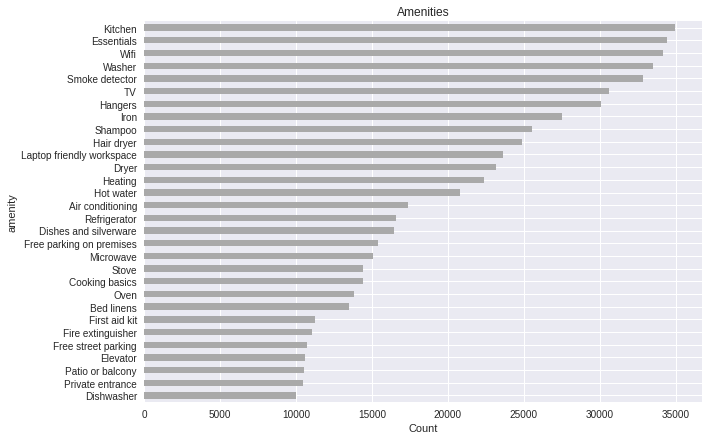

In [33]:
# plot the Top 20
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(10,7), legend=False, color='darkgrey',
                                                      title='Amenities')
plt.xlabel('Count');

In [34]:
df = df_raw

Let's add columns with amenities that are somewhat unique and not offered by all hosts:

- a laptop-friendly workspace
- a TV
- patio or balcony
- air conditioning and
- free parking

After doing this, let's drop the original column:

In [35]:
df['Laptop_friendly_workspace'] = df['amenities'].str.contains('Laptop friendly workspace')
df['TV'] = df['amenities'].str.contains('TV')
df['Balcony'] = df['amenities'].str.contains('Patio or balcony')
df['Air_Conditioning'] = df['amenities'].str.contains('Air conditioning')
df['Free_Parking'] = df['amenities'].str.contains('Free parking on premises') | df['amenities'].str.contains('Free street parking')

In [36]:
df.drop(['amenities'], axis=1, inplace=True)

## Make sure engineered features make sense

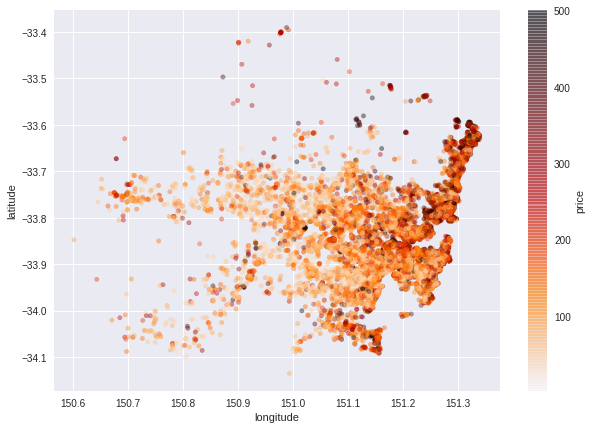

In [37]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False);

__> Price Differences by Neighbourhood__

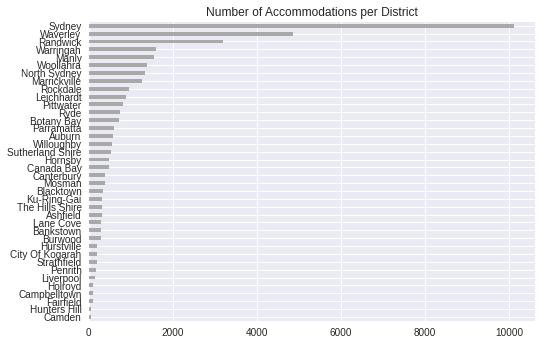

In [38]:
df['neighbourhood'].value_counts().sort_values().plot(kind='barh', color='darkgrey')
plt.title('Number of Accommodations per District');

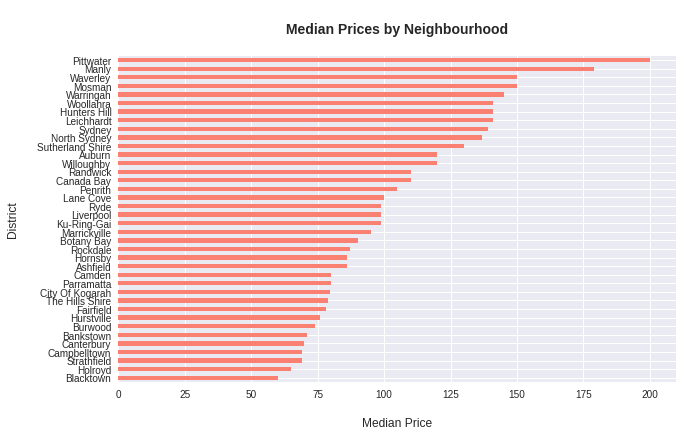

In [39]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_grouped = pd.DataFrame(df.groupby(['neighbourhood'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

# plot this 
df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='neighbourhood', y='price', 
                figsize=(10,6), legend=False, color='salmon')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nMedian Prices by Neighbourhood\n', fontsize=14, fontweight='bold');

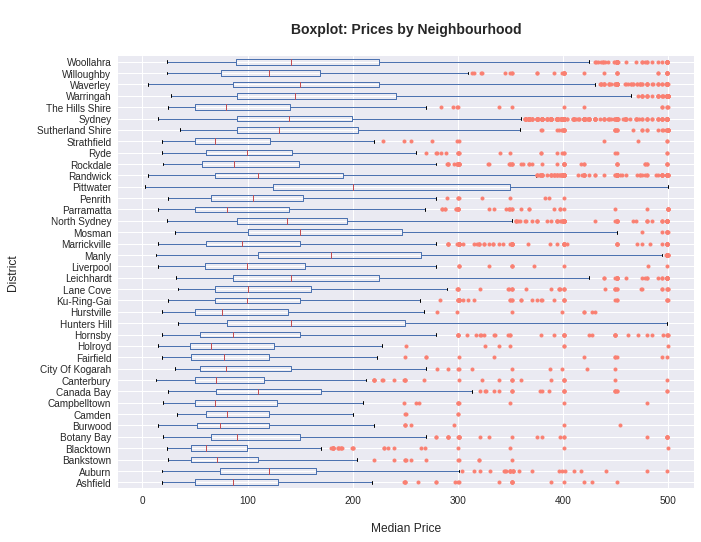

In [40]:
red_square = dict(markerfacecolor='salmon', markeredgecolor='salmon', marker='.')

df.boxplot(column='price', by='neighbourhood', 
           flierprops=red_square, vert=False, figsize=(10,8))

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nBoxplot: Prices by Neighbourhood\n', fontsize=14, fontweight='bold')

# get rid of automatic boxplot title
plt.suptitle('');

__> Price Differences by Accommodation Distance to Transport Services__

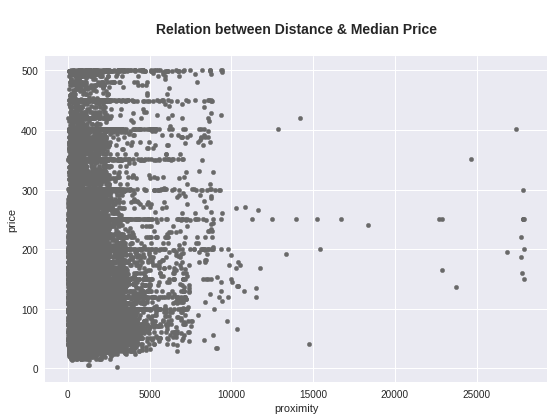

In [41]:
df.plot.scatter(x="proximity", y="price", figsize=(9,6), c='dimgrey')
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');

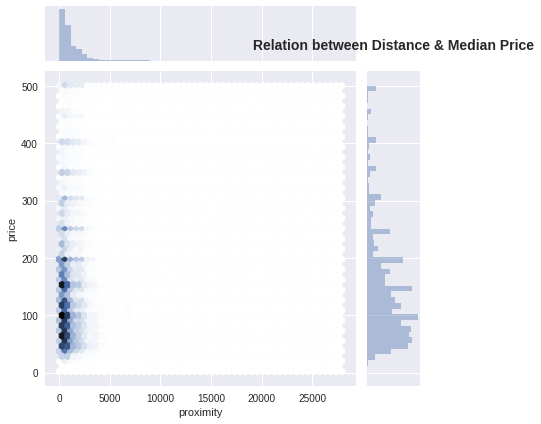

In [42]:
sns.jointplot(x=df["proximity"], y=df["price"], kind='hex')
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');

__> Price Differences by Distance From Coastline__

It appears from the price, latitude, longitude heatmap that locations closer to the coast appear to have higher prices. Let's put that to the test.

In [43]:
import os

path = '../data/coastline/'
D = np.load(os.path.join(path,'coastal_basemap_data.npy'), allow_pickle=True).tolist()
lons,lats = D['lons'],D['lats']

def distance_from_coast(lons, lats, lon,lat):
    dists = np.sqrt((lons-lon)**2+(lats-lat)**2)

    return np.min(dists)

In [44]:
# df['Coastline_Dist'] = df.apply(lambda x : distance_from_coast(
#     lons, lats, x['longitude'], x['latitude']), axis=1)
# merge full dataframe + add specific columns from df_2
df_coast = pd.read_csv('../data/coastline_dat.csv')
df = pd.merge(df, df_coast[['id', 'Coastline_Dist']], 
              left_on='id', right_on='id')


In [45]:
df['Coastline_Dist'].describe()

count    37042.000000
mean         0.029277
std          0.048619
min          0.000101
25%          0.008329
50%          0.014610
75%          0.027126
max          0.475286
Name: Coastline_Dist, dtype: float64

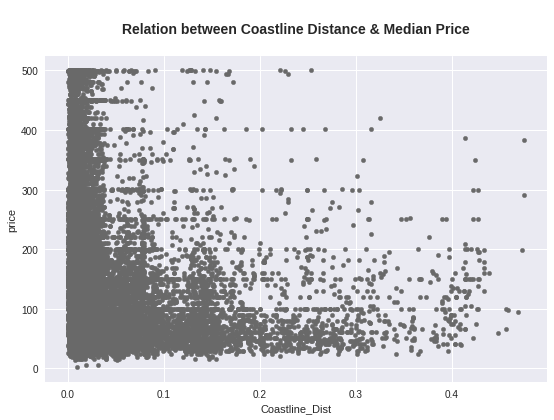

In [46]:
df.plot.scatter(x="Coastline_Dist", y="price", figsize=(9,6), c='dimgrey')
plt.title('\nRelation between Coastline Distance & Median Price\n', fontsize=14, fontweight='bold');

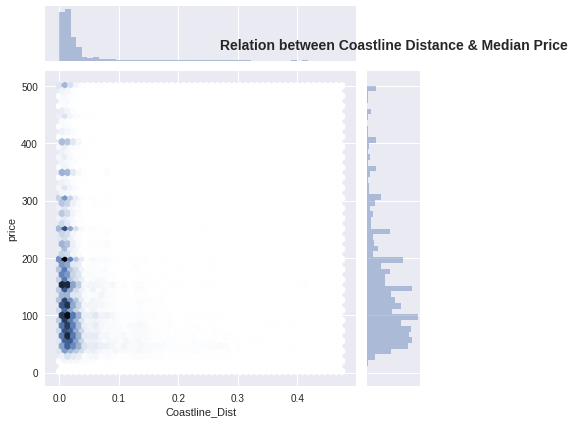

In [47]:
sns.jointplot(x=df["Coastline_Dist"], y=df["price"], kind='hex')
plt.title('\nRelation between Coastline Distance & Median Price\n', fontsize=14, fontweight='bold');

In [48]:
# # save the df for not having to rerun alg for calculating coastline distances
# header = ["id", "Coastline_Dist"]
# df.to_csv('../data/coastline_dat.csv', columns = header)

## Modeling the Data

### Preparing Target and Features

In [49]:
df.columns

Index(['id', 'description', 'host_has_profile_pic', 'neighbourhood',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'bed_type', 'price', 'cleaning_fee',
       'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'proximity', 'Laptop_friendly_workspace', 'TV', 'Balcony',
       'Air_Conditioning', 'Free_Parking', 'Coastline_Dist'],
      dtype='object')

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37042 entries, 0 to 37041
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         37042 non-null  int64  
 1   description                35818 non-null  object 
 2   host_has_profile_pic       37042 non-null  object 
 3   neighbourhood              37042 non-null  object 
 4   latitude                   37042 non-null  float64
 5   longitude                  37042 non-null  float64
 6   property_type              37042 non-null  object 
 7   room_type                  37042 non-null  object 
 8   accommodates               37042 non-null  int64  
 9   bathrooms                  37042 non-null  float64
 10  bedrooms                   37042 non-null  float64
 11  bed_type                   37042 non-null  object 
 12  price                      37042 non-null  float64
 13  cleaning_fee               37042 non-null  flo

Let's drop some columns we don't need. E.g. `property_type`, `latitude` and `longitude` are no longer helpful. Let's also drop neighbourhood since we're working with the distance from the coastline as a measure of where the listing is.

In [51]:
df.drop(['latitude', 'longitude', 'property_type', 'neighbourhood', 'is_business_travel_ready'], axis=1, inplace=True)

Now let's convert all string columns into categorical ones:

In [52]:
for col in ['host_has_profile_pic', 'room_type', 'bed_type', 'instant_bookable', 'cancellation_policy']:
    df[col] = df[col].astype('category')

In [53]:
# define our target
target = df[["price"]]

# define our features 
features = df.drop(["price", "id"], axis=1)

### Recoding Categorical Features

In [54]:
num_feats = features.select_dtypes(include=['float64', 'int64', 'bool']).copy()

# one-hot encoding of categorical features
cat_feats = features.select_dtypes(include=['category']).copy()
cat_feats = pd.get_dummies(cat_feats)

In [55]:
features_recoded = pd.concat([num_feats, cat_feats], axis=1)


In [56]:
print(features_recoded.shape)
features_recoded.head(2)

(37042, 34)


,accommodates,bathrooms,bedrooms,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,proximity,Laptop_friendly_workspace,...,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_f,instant_bookable_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
0,1,1.0,1.0,0.0,0.0,0.0,1,2,714.152785,False,...,0,1,1,0,0,1,0,0,0,0
1,6,3.0,3.0,100.0,900.0,40.0,6,5,1614.550356,True,...,0,1,1,0,0,0,0,1,0,0


In [57]:
features_recoded.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'cleaning_fee',
       'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',
       'proximity', 'Laptop_friendly_workspace', 'TV', 'Balcony',
       'Air_Conditioning', 'Free_Parking', 'Coastline_Dist',
       'host_has_profile_pic_f', 'host_has_profile_pic_t',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room', 'bed_type_Airbed',
       'bed_type_Couch', 'bed_type_Futon', 'bed_type_Pull-out Sofa',
       'bed_type_Real Bed', 'instant_bookable_f', 'instant_bookable_t',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60'],
      dtype='object')

# Hypothesis Testing

- Null Hypothesis ($H_0$) - AirBnB listing prices are not affected by the measure of their distance from the New South Wales shoreline.
- Alternate Hypothesis ($H_1$) - AirBnB listing prices **are** affected by the measure of their distance from the New South Wales shoreline

In [58]:
import statsmodels.api as sm
import statsmodels

Xvar = features_recoded.copy()
Yvar = target

In [59]:
Xvar = statsmodels.tools.tools.add_constant(Xvar, has_constant='raise')

In [60]:
linearModel1=sm.OLS(Yvar, Xvar.astype(float), hasconst=True).fit()

In [61]:
linearModel1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     1428.
Date:                Fri, 22 May 2020   Prob (F-statistic):               0.00
Time:                        06:13:02   Log-Likelihood:            -2.0984e+05
No. Observations:               37042   AIC:                         4.197e+05
Df Residuals:                   37012   BIC:                         4.200e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
const                                              17.2713      5.261      3.283      0.001       6.960      27.582
accommodates                                       12.3630      0.345     35.814      0.000      11.686      13.040
bathrooms                                           7.3602      0.685     10.750      0.000       6.018       8.702
bedrooms                                           24.7464      0.631     39.239      0.000      23.510      25.983
cleaning_fee                                        0.1696      0.007     23.814      0.000       0.156       0.184
security_deposit                                    0.0129      0.001     14.535      0.000       0.011       0.015
extra_people                                        0.0336      0.018      1.912      0.056      -0.001       0.068
guests_included                                    -2.8386      0.375     -7.562      0.000      -3.574      -2.103
minimum_nights                                     -0.0333      0.018     -1.834      0.067      -0.069       0.002
proximity                                           0.0059      0.000     19.637      0.000       0.005       0.006
Laptop_friendly_workspace                          -2.7643      0.791     -3.496      0.000      -4.314      -1.215
TV                                                 11.8970      1.013     11.749      0.000       9.912      13.882
Balcony                                            -3.4705      0.884     -3.924      0.000      -5.204      -1.737
Air_Conditioning                                    7.9643      0.788     10.106      0.000       6.420       9.509
Free_Parking                                       -8.2117      0.790    -10.398      0.000      -9.760      -6.664
Coastline_Dist                                   -306.8649      8.003    -38.346      0.000    -322.550    -291.180
host_has_profile_pic_f                             19.1123      4.755      4.020      0.000       9.793      28.431
host_has_profile_pic_t                             -1.8410      3.734     -0.493      0.622      -9.160       5.478
room_type_Entire home/apt                          26.4753      1.867     14.177      0.000      22.815      30.135
room_type_Hotel room                               66.3090      3.771     17.585      0.000      58.918      73.700
room_type_Private room                            -23.3769      1.823    -12.825      0.000     -26.950     -19.804
room_type_Shared room                             -52.1360      2.565    -20.323      0.000     -57.164     -47.108
bed_type_Airbed                                    -0.2256     15.402     -0.015      0.988     -30.413      29.962
bed_type_Couch                                     -3.8892     16.3

From our results, it shows that the P-value for a two-tailed T-Test on our `Coastline_Dist` feature shows that it is close to $0.000$. This means, that with a 95% confidence interval, we can say that the null hypothesis can be rejected. 

An interpretation of $H_0$ and $H_1$ from the values above can be inferred as follows. The $H_0$ states that the coefficient for the `Coastline_Dist` feature is $0$, i.e. the prices regressed using `Coastline_Dist` will be unaffected by any change in `Coastline_Dist`. However, $H_1$ states that the coefficient is $-429.2069$, which means - that for every 1 unit increase in distance from the coast line, the price drops by 429 dollars. The t-statistic caluclated using the Standard Error measures to $-34.893$, which gives us a P-value close to $0.000$. Using this p-value, we can reject the null hypothesis. 

# Feature Selection using Backward Elimination

We create a multivariable linear regressor by eliminating features iteratively, and building a model with a reduced set of features in each iteration. This is performed until all the reamining features have a p-value of less than $0.05$, i.e. we can accept all features to have a coefficient higher than 0 with a 95% confidence interval.

In [62]:


drop_cols1 = ['host_has_profile_pic_f', 'bed_type_Airbed', 'bed_type_Couch', 'bed_type_Futon', 'bed_type_Pull-out Sofa', 
             'bed_type_Real Bed', 'instant_bookable_f', 'instant_bookable_t',
             'cancellation_policy_flexible', 'cancellation_policy_moderate', 'cancellation_policy_strict',
             'cancellation_policy_strict_14_with_grace_period']
Xvar1 = Xvar.drop(drop_cols1, axis=1)

In [63]:
Xvar1.columns

Index(['const', 'accommodates', 'bathrooms', 'bedrooms', 'cleaning_fee',
       'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',
       'proximity', 'Laptop_friendly_workspace', 'TV', 'Balcony',
       'Air_Conditioning', 'Free_Parking', 'Coastline_Dist',
       'host_has_profile_pic_t', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60'],
      dtype='object')

In [64]:
linearModel2=sm.OLS(Yvar, Xvar1.astype(float), hasconst=True).fit()

In [65]:
linearModel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     1956.
Date:                Fri, 22 May 2020   Prob (F-statistic):               0.00
Time:                        06:13:02   Log-Likelihood:            -2.0992e+05
No. Observations:               37042   AIC:                         4.199e+05
Df Residuals:                   37020   BIC:                         4.201e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  58.6851      5.562     10.552      0.000      47.784      69.586
accommodates                           12.1997      0.345     35.349      0.000      11.523      12.876
bathrooms                               7.3977      0.686     10.782      0.000       6.053       8.743
bedrooms                               25.3608      0.628     40.354      0.000      24.129      26.593
cleaning_fee                            0.1642      0.007     23.500      0.000       0.151       0.178
security_deposit                        0.0135      0.001     15.199      0.000       0.012       0.015
extra_people                            0.0331      0.018      1.885      0.059      -0.001       0.067
guests_included                        -3.1082      0.375     -8.281      0.000      -3.844      -2.372
minimum_nights                         -0.0272      0.018     -1.495      0.135      -0.063       0.008
proximity                               0.0060      0.000     20.141      0.000       0.005       0.007
Laptop_friendly_workspace              -3.2886      0.790     -4.160      0.000      -4.838      -1.739
TV                                     12.2734      1.014     12.107      0.000      10.286      14.260
Balcony                                -4.5744      0.878     -5.211      0.000      -6.295      -2.854
Air_Conditioning                        7.6160      0.788      9.663      0.000       6.071       9.161
Free_Parking                           -8.5570      0.791    -10.820      0.000     -10.107      -7.007
Coastline_Dist                       -308.8154      8.013    -38.537      0.000    -324.522    -293.109
host_has_profile_pic_t                -20.7912      6.753     -3.079      0.002     -34.027      -7.556
room_type_Entire home/apt              37.4624      1.827     20.506      0.000      33.882      41.043
room_type_Hotel room                   75.1099      3.895     19.283      0.000      67.475      82.744
room_type_Private room                -12.4009      1.773     -6.994      0.000     -15.876      -8.926
room_type_Shared room                 -41.4863      2.603    -15.938      0.000     -46.588     -36.384
cancellation_policy_super_strict_30    25.8753      7.612      3.399      0.001      10.956      40.794
cancellation_policy_super_strict_60    29.6975      7.150      4.154      0.000      15.684      43.711
==============================================================================
Omnibus:                    10733.981   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59403.438
Skew:                           1.285   Prob(JB):                         0.00
Kurtosis:                       8.646   Cond. No.              

In [66]:
drop_cols2 = ['room_type_Private room', 'room_type_Shared room', 'cancellation_policy_super_strict_30']
Xvar2 = Xvar1.drop(drop_cols2, axis=1)

In [67]:
linearModel3=sm.OLS(Yvar, Xvar2.astype(float), hasconst=True).fit()

In [68]:
linearModel3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     2147.
Date:                Fri, 22 May 2020   Prob (F-statistic):               0.00
Time:                        06:13:03   Log-Likelihood:            -2.0999e+05
No. Observations:               37042   AIC:                         4.200e+05
Df Residuals:                   37022   BIC:                         4.202e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  44.0793      6.841      6.444      0.000      30.671      57.487
accommodates                           12.1318      0.346     35.100      0.000      11.454      12.809
bathrooms                               7.0113      0.687     10.213      0.000       5.666       8.357
bedrooms                               25.4162      0.629     40.380      0.000      24.182      26.650
cleaning_fee                            0.1687      0.007     24.303      0.000       0.155       0.182
security_deposit                        0.0134      0.001     15.057      0.000       0.012       0.015
extra_people                            0.0272      0.018      1.551      0.121      -0.007       0.062
guests_included                        -3.0486      0.376     -8.108      0.000      -3.785      -2.312
minimum_nights                         -0.0296      0.018     -1.622      0.105      -0.065       0.006
proximity                               0.0061      0.000     20.284      0.000       0.005       0.007
Laptop_friendly_workspace              -3.2680      0.790     -4.136      0.000      -4.817      -1.719
TV                                     12.5529      1.015     12.365      0.000      10.563      14.543
Balcony                                -4.4232      0.879     -5.032      0.000      -6.146      -2.700
Air_Conditioning                        7.7201      0.789      9.783      0.000       6.173       9.267
Free_Parking                           -8.1643      0.791    -10.319      0.000      -9.715      -6.614
Coastline_Dist                       -307.2007      8.026    -38.276      0.000    -322.932    -291.470
host_has_profile_pic_t                -20.2371      6.764     -2.992      0.003     -33.496      -6.979
room_type_Entire home/apt              51.2073      0.956     53.557      0.000      49.333      53.081
room_type_Hotel room                   89.4068      4.536     19.709      0.000      80.516      98.298
cancellation_policy_super_strict_60    28.9774      7.161      4.047      0.000      14.942      43.013
==============================================================================
Omnibus:                    10644.535   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58442.648
Skew:                           1.276   Prob(JB):                         0.00
Kurtosis:                       8.599   Cond. No.                     4.41e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.41e+04. This might indicate that there are
strong multicollinearity or other 

The R-squared value for the linear models drop after performing feature selection, so we're better off without dropping them.

# Try out different models

Methodology - Use grid search cv to find the best parameters using cross validation of kfolds = 10 for each linear model and also xgboost.

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


In [70]:
X_train, X_test, y_train, y_test = train_test_split(features_recoded, target, test_size=0.2, random_state=42)

In [71]:
# # Split and scale the data
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test  = sc.transform(X_test)

## Linear Regressor

In [72]:
from sklearn.linear_model import LinearRegression

In [73]:
# Grid search parameters
model = LinearRegression()
param_grid = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True]}
gl = GridSearchCV(model,param_grid, cv=10, scoring='r2')
gl.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'copy_X': [True], 'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [74]:
print('Grid search mean and stdev:\n')
for params, mean_score, std_dev in zip(gl.cv_results_['params'], gl.cv_results_['mean_test_score'], gl.cv_results_['std_test_score']):
    print("{:0.3f} (+/-{:0.03f}) for {}".format(
            mean_score, std_dev * 2, params))
print('\nLinear Regressor best params:\n', gl.best_params_)
print('\nLinear Regressor r-squared on training data:\n', gl.score(X_train, y_train))
print('\nLinear Regressor r-squared on test data:\n', gl.score(X_test, y_test))

Grid search mean and stdev:

-1683715270578529632256.000 (+/-10102291623471176744960.000) for {'copy_X': True, 'fit_intercept': True, 'normalize': True}
0.522 (+/-0.051) for {'copy_X': True, 'fit_intercept': True, 'normalize': False}
0.522 (+/-0.051) for {'copy_X': True, 'fit_intercept': False, 'normalize': True}
0.522 (+/-0.051) for {'copy_X': True, 'fit_intercept': False, 'normalize': False}

Linear Regressor best params:
 {'copy_X': True, 'fit_intercept': False, 'normalize': True}

Linear Regressor r-squared on training data:
 0.5263774151473837

Linear Regressor r-squared on test data:
 0.5344051252562899


In [75]:
pd.DataFrame(gl.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_copy_X,param_fit_intercept,param_normalize,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.156888,0.038331,0.014592,0.003154,True,True,True,"{'copy_X': True, 'fit_intercept': True, 'norma...",-1.683715e+22,0.452096,...,0.526200,0.515971,0.554631,0.537568,0.527161,0.526030,0.528357,-1.683715e+21,5.051146e+21,4
1,0.157433,0.036169,0.019869,0.006921,True,True,False,"{'copy_X': True, 'fit_intercept': True, 'norma...",5.181691e-01,0.452354,...,0.526179,0.516118,0.554584,0.537422,0.527176,0.526064,0.528390,5.220927e-01,2.540950e-02,3
2,0.147557,0.041751,0.013637,0.004254,True,False,True,"{'copy_X': True, 'fit_intercept': False, 'norm...",5.182350e-01,0.452354,...,0.526179,0.516118,0.554584,0.537422,0.527176,0.526064,0.528390,5.220993e-01,2.540849e-02,1
3,0.142561,0.046387,0.015900,0.007553,True,False,False,"{'copy_X': True, 'fit_intercept': False, 'norm...",5.182350e-01,0.452354,...,0.526179,0.516118,0.554584,0.537422,0.527176,0.526064,0.528390,5.220993e-01,2.540849e-02,1


## XGBoost Regressor

In [76]:
import xgboost as xgb

Some of the important hyperparameters to tune an XGBoost are:

- `n_estimators`    = Number of trees one wants to build.
- `learning_rate`   = Rate at which our model learns patterns in data. After every round, it shrinks the feature weights to reach the best optimum.
- `max_depth`   = Determines how deeply each tree is allowed to grow during any boosting round.
- `colsample_bytree` = Percentage of features used per tree.
- `gamma`   = Specifies the minimum loss reduction required to make a split.

In [77]:
booster = xgb.XGBRegressor()
# create Grid
param_grid = {'n_estimators': [200, 250],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [7, 8, 9],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}
# instantiate the tuned random forest
gbs = GridSearchCV(booster, param_grid, cv=10, n_jobs=-1, scoring='r2')
# train the tuned random forest
gbs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estim...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={

In [78]:
# gbs = load_model('_colsample_bytree_0.6___gamma_0.2___learning_rate_0.05___max_depth_9___n_estimators_200__gbs', "../models/")

In [79]:
print('Grid search mean and stdev:\n')
for params, mean_score, std_dev in zip(gbs.cv_results_['params'], gbs.cv_results_['mean_test_score'], gbs.cv_results_['std_test_score']):
    print("{:0.3f} (+/-{:0.03f}) for {}".format(
            mean_score, std_dev * 2, params))
print('\nLinear Regressor best params:\n', gbs.best_params_)
print('\nLinear Regressor r-squared on training data:\n', gbs.score(X_train, y_train))
print('\nLinear Regressor r-squared on test data:\n', gbs.score(X_test, y_test))

Grid search mean and stdev:

0.547 (+/-0.025) for {'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}
0.587 (+/-0.026) for {'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 250}
0.552 (+/-0.024) for {'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 200}
0.592 (+/-0.025) for {'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 250}
0.555 (+/-0.024) for {'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200}
0.594 (+/-0.025) for {'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 250}
0.624 (+/-0.029) for {'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}
0.624 (+/-0.029) for {'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 250}
0.6


Linear Regressor r-squared on training data:
 0.7913978327843548

Linear Regressor r-squared on test data:
 0.6394257824298264


In [80]:
from sklearn.externals import joblib

def save_model(name, filepath, model):
    if not os.path.exists(os.path.dirname(filepath)):
        try:
            os.makedirs(os.path.dirname(filepath))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    param_name = "_".join([f"_{k}_{v}_" for k,v in model.best_params_.items()])
    joblib.dump(model, os.path.join(filepath, f"{param_name}_{name}"))

def load_model(name, filepath):
    model = joblib.load(os.path.join(filepath, name))
    return model

In [81]:
save_model("gbs_reduced_price", "../models/", gbs)

In [82]:
pd.DataFrame(gbs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,18.233933,0.819401,0.110294,0.036206,0.6,0,0.01,7,200,"{'colsample_bytree': 0.6, 'gamma': 0.0, 'learn...",...,0.547195,0.534675,0.568205,0.558777,0.542482,0.541875,0.562105,0.547173,0.012298,162
1,24.041814,0.487352,0.139432,0.036373,0.6,0,0.01,7,250,"{'colsample_bytree': 0.6, 'gamma': 0.0, 'learn...",...,0.587681,0.571187,0.609567,0.598876,0.583467,0.582506,0.598589,0.586856,0.012809,132
2,21.872230,0.550581,0.128687,0.031415,0.6,0,0.01,8,200,"{'colsample_bytree': 0.6, 'gamma': 0.0, 'learn...",...,0.553046,0.540137,0.572157,0.563329,0.546563,0.548078,0.567450,0.552169,0.012130,149
3,27.417580,0.962071,0.189343,0.056719,0.6,0,0.01,8,250,"{'colsample_bytree': 0.6, 'gamma': 0.0, 'learn...",...,0.593252,0.576528,0.613037,0.603288,0.587559,0.588442,0.603537,0.591543,0.012613,119
4,26.268850,1.161090,0.170854,0.036217,0.6,0,0.01,9,200,"{'colsample_bytree': 0.6, 'gamma': 0.0, 'learn...",...,0.555720,0.542345,0.574125,0.565409,0.549011,0.553000,0.570632,0.554860,0.012008,141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,32.908407,0.995201,0.138784,0.023943,1,0.2,0.1,7,250,"{'colsample_bytree': 1, 'gamma': 0.2, 'learnin...",...,0.623046,0.590109,0.636879,0.633058,0.616475,0.613971,0.622384,0.616599,0.014746,94
158,29.569302,0.782000,0.128562,0.034624,1,0.2,0.1,8,200,"{'colsample_bytree': 1, 'gamma': 0.2, 'learnin...",...,0.620681,0.585695,0.635708,0.632233,0.611800,0.615713,0.618657,0.614857,0.015534,99
159,36.464593,1.046012,0.155132,0.032404,1,0.2,0.1,8,250,"{'colsample_bytree': 1, 'gamma': 0.2, 'learnin...",...,0.620267,0.584065,0.632493,0.630274,0.610791,0.613195,0.617706,0.613114,0.015497,103
160,33.988693,0.949067,0.138173,0.024684,1,0.2,0.1,9,200,"{'colsample_bytree': 1, 'gamma': 0.2, 'learnin...",...,0.618947,0.587142,0.628063,0.627109,0.607345,0.622769,0.617527,0.612739,0.014461,105


# Evaluating Models

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import math
import numpy as np

def pipeline(alg, features, target, alg_params=None, drop=False, dropped_cols=None):
    if drop and not dropped_cols:
        raise Exception("No columns specified after setting drop parameter to true.")

    if drop:
        features = features.drop(dropped_cols, axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    if not alg_params:
        clf = alg()
    else:
        clf = alg(**alg_params)

    
    _ = clf.fit(X_train, y_train)
    if alg != xgb.XGBRegressor:
        print('Intercept:', clf.intercept_)
        print('Coefficients:\n', clf.coef_)
    print('\nR-squared:', clf.score(X_train, y_train))
    
    # We can predict the median price for a new neighbourhoods
    print('\nPredicted price of first five data points from test split:\n', clf.predict(X_test)[:5])

#     if alg == xgb.XGBRegressor:
#         # We can also calculate the standard error
#         stderr = math.sqrt(np.mean((y_train - clf.predict(X_train.reshape(len(X_train), 1)))**2))
#         print('\nStandard error:', stderr)
#     else:
#         # We can also calculate the standard error
#         stderr = math.sqrt(np.mean((y_train - clf.predict(X_train)**2)))
#         print('\nStandard error:', stderr)
    
    return clf, X_train, X_test, y_train, y_test

def evaluate_model(clf, X_train, X_test, y_train, y_test, _type='xgb'):
    se2 = math.sqrt(mean_squared_error(y_train, clf.predict(X_train)))
    print('Standard error using sklearn.metrics:', se2)

    print('\nPredictions should be within {:.1f} dollars at 95% confidence according to training data.'.format(2*se2))
    se_test = math.sqrt(mean_squared_error(y_test, clf.predict(X_test)))
    print('Predictions should be within {:.1f} dollars at 95% confidence according to test data.'.format(2*se_test))
    
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    if _type == 'xgb':
        y_pred_train = y_pred_train.reshape(len(y_pred_train), 1)
        y_pred_test = y_pred_test.reshape(len(y_pred_test), 1)
    print('\nResidual plot for training data (blue) and test data (green):')
    _ = plt.scatter(y_pred_train, y_train-y_pred_train, c='blue', s=40, alpha=0.5, edgecolor='white')
    _ = plt.scatter(y_pred_test, y_test-y_pred_test, c='green', s=40, alpha=0.5, edgecolor='white')
    _ = plt.xlim([-100, 600])
    _ = plt.ylim([-500, 500])
    _ = plt.plot([-100,600], [0,0], c='black')
    _ = plt.ylabel('Residuals ($y - \hat{y}$)')
    _ = plt.xlabel('Predicted values ($\hat{y}$)')


## Linear Regressor

In [84]:
lm, X_train, X_test, y_train, y_test = pipeline(LinearRegression, features_recoded, target,  alg_params=gl.best_params_)

Intercept: 0.0
Coefficients:
 [[ 1.29797084e+01  7.47758774e+00  2.36843462e+01  1.66525838e-01
   1.30090560e-02  1.54973599e-02 -2.75604076e+00 -3.36369624e-02
   6.16412222e-03 -2.39544298e+00  1.22957963e+01 -3.57157537e+00
   7.68238386e+00 -8.60225716e+00 -3.03623286e+02  2.34777399e+01
   3.02151750e+00  2.82345653e+01  6.79799156e+01 -2.04567891e+01
  -4.92584345e+01 -1.17611294e+01  1.58615236e+01  7.64301141e+00
   2.78455924e+00  1.19712926e+01  1.66598153e+01  9.83944214e+00
   1.94577157e+01  1.12022998e+01 -1.09800158e+02  1.72242103e+01
   4.44999905e+01  4.39151992e+01]]

R-squared: 0.5263774151473837

Predicted price of first five data points from test split:
 [[ 80.20273773]
 [ 61.91845688]
 [197.43004678]
 [ 97.01970676]
 [226.17413825]]


Standard error using sklearn.metrics: 69.99993453601996

Predictions should be within 140.0 dollars at 95% confidence according to training data.
Predictions should be within 138.3 dollars at 95% confidence according to test data.

Residual plot for training data (blue) and test data (green):


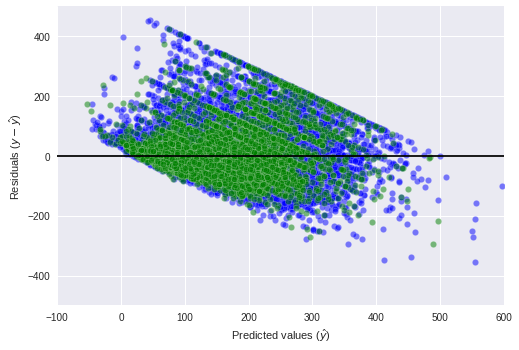

In [102]:
evaluate_model(lm, X_train, X_test, y_train, y_test, _type='lm')

## XGB Regressor

In [86]:
gb, X_train, X_test, y_train, y_test = pipeline(xgb.XGBRegressor, features_recoded, target,  alg_params=gbs.best_params_)


R-squared: 0.7913978327843548

Predicted price of first five data points from test split:
 [113.22892   57.154633 189.40007   91.270424 160.88252 ]


Standard error using sklearn.metrics: 46.45589592391492

Predictions should be within 92.9 dollars at 95% confidence according to training data.
Predictions should be within 121.7 dollars at 95% confidence according to test data.

Residual plot for training data (blue) and test data (green):


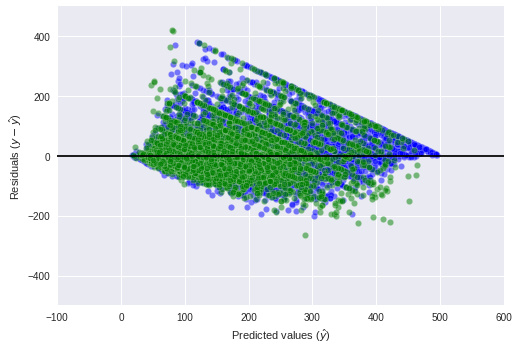

In [103]:
evaluate_model(gb, X_train, X_test, y_train, y_test, _type='xgb')

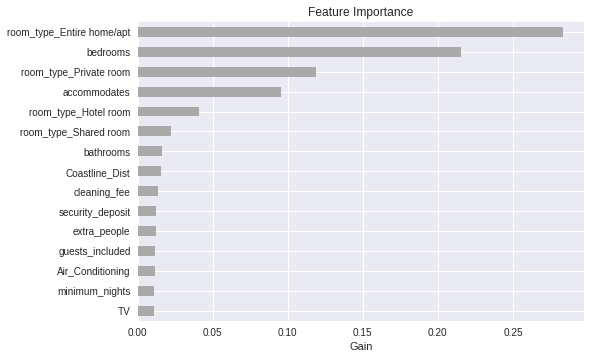

In [88]:
# plot the important features
feat_importances = pd.Series(gb.feature_importances_, index=features_recoded.columns)
_ = feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey')
_ = plt.xlabel('Gain');
_ = plt.title('Feature Importance')

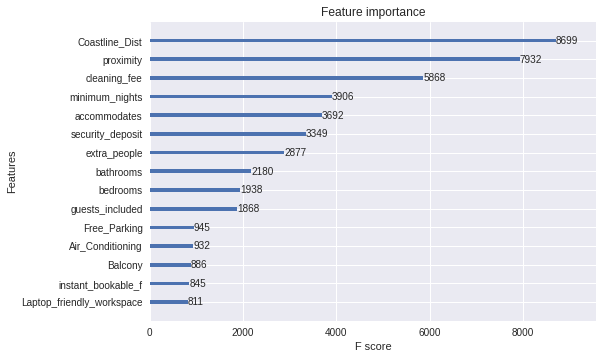

In [89]:
from xgboost import plot_importance

ax = plot_importance(gb, max_num_features=15)